<a href="https://colab.research.google.com/github/Tuevu110405/Cassava-leaf-classification-with-Resnet18/blob/main/MyRESNET18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 68
set_seed(seed)

Download and process datasets

In [3]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip
!unzip  /content/cassavaleafdata.zip


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
 

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64

#EDA


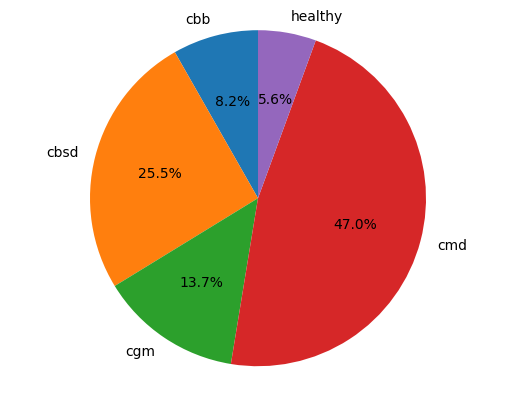

CBB: 466
CBSD: 1443
CGM: 773
CMD: 2658
Healthy: 316
Total: 5656


In [5]:
import matplotlib.pyplot as plt


data_dir = '/content/cassavaleafdata'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

cbb = len(os.listdir(os.path.join(train_dir, 'cbb')))
cbsd = len(os.listdir(os.path.join(train_dir, 'cbsd')))
cgm = len(os.listdir(os.path.join(train_dir, 'cgm')))
cmd = len(os.listdir(os.path.join(train_dir, 'cmd')))
healthy = len(os.listdir(os.path.join(train_dir, 'healthy')))

#plot pie chart for them
data = {'cbb': cbb, 'cbsd': cbsd, 'cgm': cgm, 'cmd': cmd, 'healthy': healthy}
labels = list(data.keys())
sizes = list(data.values())

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
    shadow = False, startangle=90)
ax1.axis('equal')
plt.show()

print(f"CBB: {cbb}")
print(f"CBSD: {cbsd}")
print(f"CGM: {cgm}")
print(f"CMD: {cmd}")
print(f"Healthy: {healthy}")
total_sample = cbb + cbsd + cgm + cmd + healthy
print(f"Total: {cbb+cbsd+cgm+cmd+healthy}")

#Data Processing

In [49]:
data_dir = '/content/cassavaleafdata'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

initial_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
]
)

#Create Dataset object
# Using ImageFolder for training
dataset_for_mean_std = datasets.ImageFolder(train_dir, transform=initial_transform)

# Create dataloader to load in batch

loader_for_mean_std = DataLoader(dataset_for_mean_std, batch_size=BATCH_SIZE, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
total_pixels = 0

for images, _ in tqdm(loader_for_mean_std, desc="Tinh mean/std"):
    images = images.permute(0, 2, 3, 1).contiguous().view(-1, 3)
    mean += images.sum(dim = 0)
    total_pixels += images.shape[0]

mean /= total_pixels
for images, _ in tqdm(loader_for_mean_std, desc="Tinh std"):
    images = images.permute(0, 2, 3, 1).contiguous().view(-1, 3)
    std += ((images - mean)**2).sum(dim=0)
    total_pixels += images.shape[0]

std /= total_pixels
std = torch.sqrt(std)

print(f"Mean: {mean}")
print(f"Std: {std}")


Tinh std:  54%|█████▍    | 48/89 [00:25<00:21,  1.87it/s]


KeyboardInterrupt: 

In [7]:
val_dir = os.path.join(data_dir, 'validation')

In [8]:
print(mean, std)

tensor([0.4479, 0.4966, 0.3222]) tensor([0.1483, 0.1466, 0.1340])


In [67]:
img_size = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)

])
tesr_val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=tesr_val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=tesr_val_transforms)

labels = train_dataset.classes
print(labels)
label_to_idx = train_dataset.class_to_idx
print(label_to_idx)
print(len(labels))






['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
{'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}
5


In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#Modelling

In [41]:
class BasicBlock(nn.Module):
    def __init__(self,in_channel, out_channel, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace = True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channel)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [42]:
import torch.nn as nn



#Build resnet 18 model
class MyResNet18(nn.Module):
    def __init__(self, num_classes):
        super(MyResNet18, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        self.in_channels = 64

        self.layer1 = self.make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # kaming he initialization
        self._initialize_weights()


    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    # kaming he initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Khởi tạo Kaiming He cho các lớp Conv2d
                # mode='fan_out' bảo toàn phương sai ở forward pass
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    # Khởi tạo bias bằng 0 nếu có
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Khởi tạo weight của BatchNorm bằng 1 và bias bằng 0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Khởi tạo trọng số của lớp Linear theo phân phối normal
                nn.init.normal_(m.weight, 0, 0.01)
                # Khởi tạo bias bằng 0
                nn.init.constant_(m.bias, 0)


# Train and evaluate function


In [43]:
def train(model, optimizer, criterion, train_loader, device, epoch= 0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []

    train_bar = tqdm(train_loader, unit = 'batch', desc = f"Epoch {epoch:3d}")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        #backward
        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        #update train_bar
        train_bar.set_postfix(
            loss= f"{loss.item():.4f}",
            acc = f"{(total_acc/total_count)*100:.2f}%"
        )
    epoch_acc = total_acc / total_count
    epoch_loss = np.mean(losses)
    # Display final result of epoch
    print(f"Epoch: {epoch}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc

In [44]:
#Evaluation function
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    epoch_acc = total_acc/total_count
    epoch_loss = sum(losses)/len(losses)
    return epoch_acc, epoch_loss

In [70]:
num_classes = len(labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"number of classes: {num_classes}")
model = MyResNet18(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs  = 10
save_model = './models'
os.makedirs(save_model, exist_ok=True)

train_accs = []
train_losses = []
eval_accs = []
eval_losses = []
best_loss_eval = 10000
tolerance = 0
epoch = 1

while tolerance < 5:
    train_loss, train_acc = train(model, optimizer, criterion,
                                  train_loader, device, epoch)

    train_accs.append(train_acc)
    train_losses.append(train_loss)

    #Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, val_loader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    #Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(model.state_dict(), os.path.join(save_model, 'best_modelCrossEntropy.pth'))
        tolerance = 1
    elif eval_loss > best_loss_eval:
        tolerance += 1
    epoch += 1

#print loss, acc and epoch
print ("-" * 59)
#Load th best model
model.load_state_dict(torch.load(os.path.join(save_model, 'best_modelCrossEntropy.pth')))
model.eval()


number of classes: 5


Epoch   1: 100%|██████████| 89/89 [00:59<00:00,  1.49batch/s, acc=56.79%, loss=0.9983]


Epoch: 1, Loss: 1.1924, Acc: 56.79%


Epoch   2: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=60.86%, loss=0.7833]


Epoch: 2, Loss: 1.0708, Acc: 60.86%


Epoch   3: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=63.14%, loss=0.8611]


Epoch: 3, Loss: 1.0204, Acc: 63.14%


Epoch   4: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=63.01%, loss=1.0981]


Epoch: 4, Loss: 1.0058, Acc: 63.01%


Epoch   5: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=64.13%, loss=1.1470]


Epoch: 5, Loss: 0.9743, Acc: 64.13%


Epoch   6: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=64.09%, loss=1.0353]


Epoch: 6, Loss: 0.9495, Acc: 64.09%


Epoch   7: 100%|██████████| 89/89 [00:59<00:00,  1.49batch/s, acc=65.10%, loss=0.6294]


Epoch: 7, Loss: 0.9318, Acc: 65.10%


Epoch   8: 100%|██████████| 89/89 [00:59<00:00,  1.49batch/s, acc=66.37%, loss=0.9276]


Epoch: 8, Loss: 0.9003, Acc: 66.37%


Epoch   9: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=67.79%, loss=1.0090]


Epoch: 9, Loss: 0.8668, Acc: 67.79%


Epoch  10: 100%|██████████| 89/89 [00:58<00:00,  1.51batch/s, acc=67.61%, loss=0.8798]


Epoch: 10, Loss: 0.8569, Acc: 67.61%


Epoch  11: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=69.04%, loss=1.1430]


Epoch: 11, Loss: 0.8273, Acc: 69.04%


Epoch  12: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=70.03%, loss=0.6831]


Epoch: 12, Loss: 0.7824, Acc: 70.03%


Epoch  13: 100%|██████████| 89/89 [00:58<00:00,  1.51batch/s, acc=70.54%, loss=1.1601]


Epoch: 13, Loss: 0.7853, Acc: 70.54%


Epoch  14: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=71.27%, loss=0.7046]


Epoch: 14, Loss: 0.7606, Acc: 71.27%


Epoch  15: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=72.33%, loss=0.5967]


Epoch: 15, Loss: 0.7281, Acc: 72.33%


Epoch  16: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=73.78%, loss=1.0288]


Epoch: 16, Loss: 0.7068, Acc: 73.78%


Epoch  17: 100%|██████████| 89/89 [00:58<00:00,  1.53batch/s, acc=73.87%, loss=0.9376]


Epoch: 17, Loss: 0.6888, Acc: 73.87%


Epoch  18: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=74.75%, loss=0.6887]


Epoch: 18, Loss: 0.6776, Acc: 74.75%


Epoch  19:  72%|███████▏  | 64/89 [00:42<00:16,  1.49batch/s, acc=75.07%, loss=0.7909]


KeyboardInterrupt: 

In [71]:
print ("-" * 59)
#Load th best model
model.load_state_dict(torch.load(os.path.join(save_model, 'best_modelCrossEntropy.pth')))
model.eval()

test_acc, test_loss = evaluate(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

-----------------------------------------------------------
Test Loss: 0.7582, Test Acc: 73.63%


In [72]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('cbb', 'cbsd', 'cgm', 'cmd', 'healthy')

# Build a text report showing the main classification metrics.
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

         cbb       0.68      0.10      0.17       155
        cbsd       0.64      0.84      0.73       481
         cgm       0.75      0.37      0.49       258
         cmd       0.81      0.93      0.87       886
     healthy       0.58      0.48      0.52       105

    accuracy                           0.74      1885
   macro avg       0.69      0.54      0.56      1885
weighted avg       0.73      0.74      0.70      1885



# Train with focal loss

In [23]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):

        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, inputs, targets):
        if self.alpha is not None and self.alpha.device != inputs.device:
            self.alpha = self.alpha.to(inputs.device)

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1-pt)**self.gamma * ce_loss

        if self.alpha is not None: # Check if self.alpha is not None before using it
            alpha = self.alpha[targets]
            focal_loss = alpha * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

#Train and evaluate with focal loss

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [65]:
print(labels)


alpha_tensor = torch.Tensor([1/ (cbb/total_sample), 1/ (cbsd/total_sample), 1/ (cgm/total_sample), 1/ (cmd/total_sample), 1/ (healthy/total_sample)])
alpha_tensor = alpha_tensor/alpha_tensor.sum()
alpha_tensor = alpha_tensor.to(device)
print(alpha_tensor)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
tensor([0.2797, 0.0903, 0.1686, 0.0490, 0.4124], device='cuda:0')


In [35]:
num_classes = len(labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyResNet18(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = FocalLoss(alpha=alpha_tensor, gamma=2.0, reduction='mean')

num_epochs  = 10
save_model = './models'
os.makedirs(save_model, exist_ok=True)

train_accs = []
train_losses = []
eval_accs = []
eval_losses = []
best_loss_eval = 10000
tolerance = 0
epoch = 1

while tolerance < 8:
    train_loss, train_acc = train(model, optimizer, criterion,
                                  train_loader, device, epoch)

    train_accs.append(train_acc)
    train_losses.append(train_loss)

    #Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, val_loader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    #Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(model.state_dict(), os.path.join(save_model, 'best_model.pth'))
        tolerance = 1
    elif eval_loss > best_loss_eval:
        tolerance += 1
    epoch += 1

#print loss, acc and epoch
print ("-" * 59)
#Load th best model
model.load_state_dict(torch.load(os.path.join(save_model, 'best_model.pth')))
model.eval()


Epoch   1: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=33.56%, loss=0.1144]


Epoch: 1, Loss: 0.1116, Acc: 33.56%


Epoch   2: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=43.64%, loss=0.1381]


Epoch: 2, Loss: 0.0983, Acc: 43.64%


Epoch   3: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=44.43%, loss=0.0748]


Epoch: 3, Loss: 0.0934, Acc: 44.43%


Epoch   4: 100%|██████████| 89/89 [00:59<00:00,  1.50batch/s, acc=45.10%, loss=0.0591]


Epoch: 4, Loss: 0.0885, Acc: 45.10%


Epoch   5: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=46.59%, loss=0.1041]


Epoch: 5, Loss: 0.0865, Acc: 46.59%


Epoch   6: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=48.20%, loss=0.0772]


Epoch: 6, Loss: 0.0828, Acc: 48.20%


Epoch   7: 100%|██████████| 89/89 [00:58<00:00,  1.51batch/s, acc=48.62%, loss=0.0781]


Epoch: 7, Loss: 0.0818, Acc: 48.62%


Epoch   8: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=50.67%, loss=0.1132]


Epoch: 8, Loss: 0.0790, Acc: 50.67%


Epoch   9: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=49.79%, loss=0.1193]


Epoch: 9, Loss: 0.0773, Acc: 49.79%


Epoch  10: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=51.61%, loss=0.0550]


Epoch: 10, Loss: 0.0737, Acc: 51.61%


Epoch  11: 100%|██████████| 89/89 [00:59<00:00,  1.51batch/s, acc=51.03%, loss=0.0445]


Epoch: 11, Loss: 0.0718, Acc: 51.03%


Epoch  12: 100%|██████████| 89/89 [00:58<00:00,  1.51batch/s, acc=50.90%, loss=0.0631]


Epoch: 12, Loss: 0.0727, Acc: 50.90%


Epoch  13: 100%|██████████| 89/89 [00:58<00:00,  1.51batch/s, acc=55.32%, loss=0.0800]


Epoch: 13, Loss: 0.0679, Acc: 55.32%


Epoch  14: 100%|██████████| 89/89 [00:58<00:00,  1.53batch/s, acc=52.05%, loss=0.0509]


Epoch: 14, Loss: 0.0694, Acc: 52.05%


Epoch  15: 100%|██████████| 89/89 [00:58<00:00,  1.53batch/s, acc=56.38%, loss=0.0399]


Epoch: 15, Loss: 0.0638, Acc: 56.38%


Epoch  16: 100%|██████████| 89/89 [01:02<00:00,  1.43batch/s, acc=56.63%, loss=0.1049]


Epoch: 16, Loss: 0.0663, Acc: 56.63%


Epoch  17: 100%|██████████| 89/89 [00:58<00:00,  1.51batch/s, acc=54.77%, loss=0.0532]


Epoch: 17, Loss: 0.0656, Acc: 54.77%


Epoch  18: 100%|██████████| 89/89 [00:58<00:00,  1.52batch/s, acc=57.83%, loss=0.0474]


Epoch: 18, Loss: 0.0595, Acc: 57.83%
-----------------------------------------------------------


MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [46]:
test_acc, test_loss = evaluate(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.9616, Test Acc: 64.88%


In [47]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('cbb', 'cbsd', 'cgm', 'cmd', 'healthy')

# Build a text report showing the main classification metrics.
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

         cbb       0.58      0.12      0.20       155
        cbsd       0.55      0.78      0.65       481
         cgm       0.36      0.06      0.10       258
         cmd       0.72      0.91      0.80       886
     healthy       0.80      0.08      0.14       105

    accuracy                           0.65      1885
   macro avg       0.60      0.39      0.38      1885
weighted avg       0.62      0.65      0.58      1885



In [73]:
image_path = "/content/cassavaleafdata/validation/cbb/validation-cbb-10.jpg"

image = Image.open(image_path)
image = tesr_val_transforms(image)

print(type(image))

model = MyResNet18(5).to(device)
model.load_state_dict(torch.load('/content/models/best_modelCrossEntropy.pth'))
model.eval()

<class 'torch.Tensor'>


MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [69]:
print(len(labels))

5
